# A sampler study

In this notebook, we perform a short study of how various samplers implemented in pyPESTO perform.

## The pipeline

First, we show a typical workflow, fully integrating the samplers with a [PEtab](https://github.com/petab-dev/petab) problem, using a toy example of a conversion reaction.

In [1]:
import pypesto
import pypesto.petab
import pypesto.optimize as optimize
import pypesto.sample as sample
import pypesto.visualize as visualize
import petab

# import to petab
petab_problem = petab.Problem.from_yaml(
    "conversion_reaction/conversion_reaction.yaml")
# import to pypesto
importer = pypesto.petab.PetabImporter(petab_problem)
# create problem
problem = importer.create_problem()

Commonly, as a first step, optimization is performed, in order to find good parameter point estimates.

In [2]:
%%time
result = optimize.minimize(problem, n_starts=10)

CPU times: user 2.5 s, sys: 332 ms, total: 2.83 s
Wall time: 2.32 s


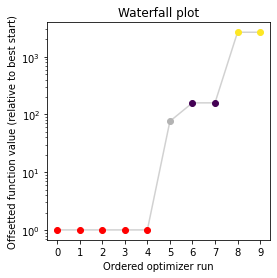

In [3]:
ax = visualize.waterfall(result, size=(4,4))

Next, we perform sampling. Here, we employ a `pypesto.sample.AdaptiveParallelTemperingSampler` sampler, which runs Markov Chain Monte Carlo (MCMC) chains on different temperatures. For each chain, we employ a `pypesto.sample.AdaptiveMetropolisSampler`. For more on the samplers see below or the API documentation.

In [4]:
sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(),
    n_chains=3)

For the actual sampling, we call the `pypesto.sample.sample` function. By passing the result object to the function, the previously found global optimum is used as starting point for the MCMC sampling.

In [5]:
%%time
result = sample.sample(problem, n_samples=10000, sampler=sampler, result=result)

100%|██████████| 10000/10000 [01:06<00:00, 150.69it/s]


CPU times: user 1min 7s, sys: 10.9 s, total: 1min 18s
Wall time: 1min 6s


When the sampling is finished, we can analyse our results. A first thing to do is to analyze the sampling burn-in:

In [6]:
sample.geweke_test(result)

0

pyPESTO provides functions to analyse both the sampling process as well as the obtained sampling result. Visualizing the traces e.g. allows to detect burn-in phases, or fine-tune hyperparameters. First, the parameter trajectories  can be visualized:

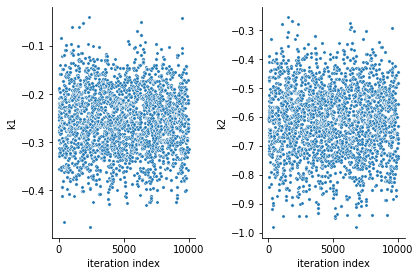

In [7]:
sample.geweke_test(result)
ax = visualize.sampling_parameter_traces(result, use_problem_bounds=False)

Next, also the log posterior trace can be visualized:

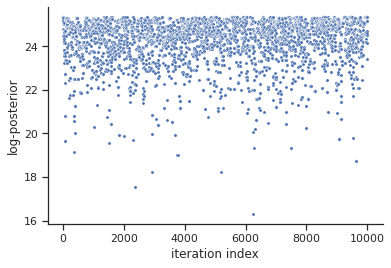

In [8]:
ax = visualize.sampling_fval_traces(result)

To visualize the result, there are various options. The scatter plot shows histograms of 1-dim parameter marginals and scatter plots of 2-dimensional parameter combinations:

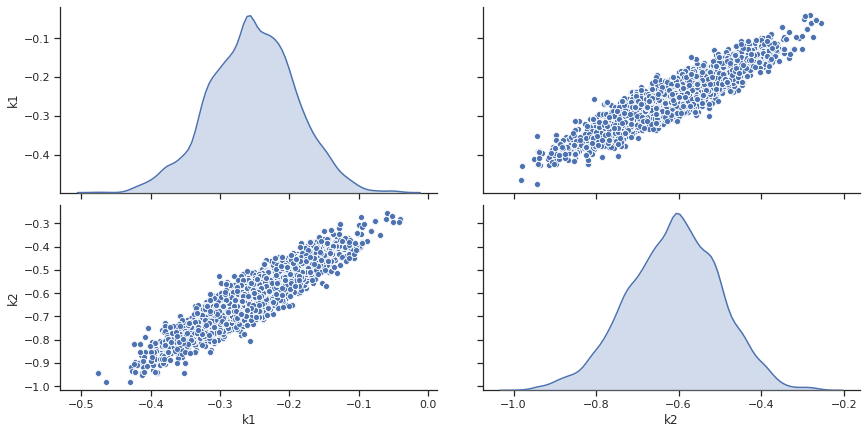

In [9]:
ax = visualize.sampling_scatter(result, size=[13,6])

`sampling_1d_marginals` allows to plot e.g. kernel density estimates or histograms (internally using [seaborn](https://seaborn.pydata.org/)):

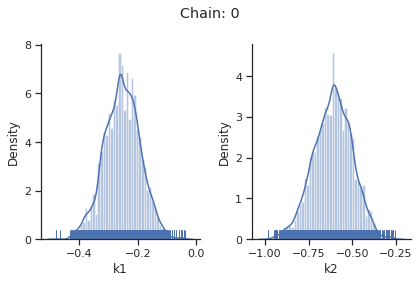

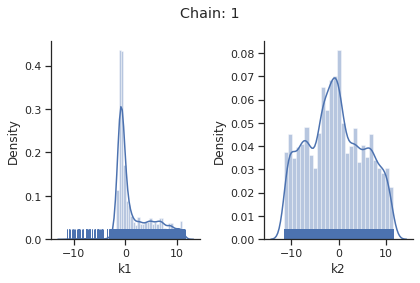

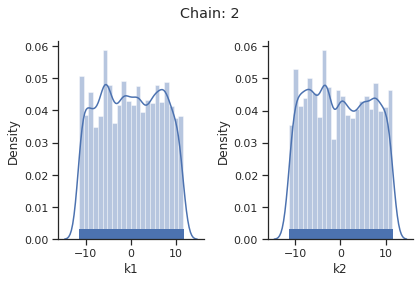

In [10]:
for i_chain in range(len(result.sample_result.betas)):
    visualize.sampling_1d_marginals(
        result, i_chain=i_chain, suptitle=f"Chain: {i_chain}")

That's it for the moment on using the sampling pipeline.

## 1-dim test problem

To compare and test the various implemented samplers, we first study a 1-dimensional test problem of a gaussian mixture density, together with a flat prior.

In [11]:
import numpy as np
from scipy.stats import multivariate_normal
import seaborn as sns
import pypesto

def density(x):
    return 0.3*multivariate_normal.pdf(x, mean=-1.5, cov=0.1) + \
        0.7*multivariate_normal.pdf(x, mean=2.5, cov=0.2)

def nllh(x):
    return - np.log(density(x))

objective = pypesto.Objective(fun=nllh)
problem = pypesto.Problem(
    objective=objective, lb=-4, ub=5, x_names=['x'])

The likelihood has two separate modes:

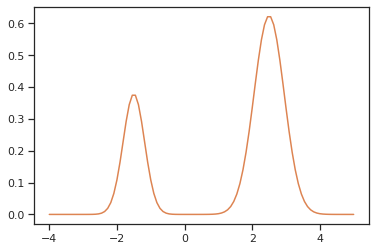

In [12]:
xs = np.linspace(-4, 5, 100)
ys = [density(x) for x in xs]

ax = sns.lineplot(xs, ys, color='C1')

### Metropolis sampler

For this problem, let us try out the simplest sampler, the `pypesto.sample.MetropolisSampler`.

In [13]:
%%time
sampler = sample.MetropolisSampler({'std': 0.5})
result = sample.sample(problem, 1e4, sampler, x0=np.array([0.5]))

100%|██████████| 10000/10000 [00:03<00:00, 2733.32it/s]

CPU times: user 3.67 s, sys: 159 ms, total: 3.83 s
Wall time: 3.68 s


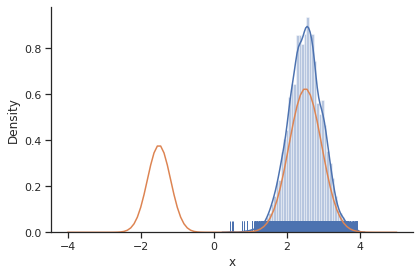

In [14]:
sample.geweke_test(result)
ax = visualize.sampling_1d_marginals(result)
ax[0][0].plot(xs, ys)

The obtained posterior does not accurately represent the distribution, often only capturing one mode. This is because it is hard for the Markov chain to jump between the distribution's two modes. This can be fixed by choosing a higher proposal variation `std`:

In [15]:
%%time
sampler = sample.MetropolisSampler({'std': 1})
result = sample.sample(problem, 1e4, sampler, x0=np.array([0.5]))

100%|██████████| 10000/10000 [00:04<00:00, 2458.62it/s]

CPU times: user 4.13 s, sys: 95.3 ms, total: 4.23 s
Wall time: 4.08 s


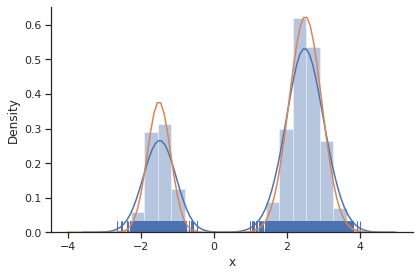

In [16]:
sample.geweke_test(result)
ax = visualize.sampling_1d_marginals(result)
ax[0][0].plot(xs, ys)

In general, MCMC have difficulties exploring multimodel landscapes. One way to overcome this is to used parallel tempering. There, various chains are run, lifting the densities to different temperatures. At high temperatures, proposed steps are more likely to get accepted and thus jumps between modes more likely.



### Parallel tempering sampler

In pyPESTO, the most basic parallel tempering algorithm is the `pypesto.sample.ParallelTemperingSampler`. It takes an `internal_sampler` parameter, to specify what sampler to use for performing sampling the different chains. Further, we can directly specify what inverse temperatures `betas` to use. When not specifying the `betas` explicitly but just the number of chains `n_chains`, an established near-exponential decay scheme is used.

In [17]:
%%time
sampler = sample.ParallelTemperingSampler(
    internal_sampler=sample.MetropolisSampler(),
    betas=[1, 1e-1, 1e-2])
result = sample.sample(problem, 1e4, sampler, x0=np.array([0.5]))

100%|██████████| 10000/10000 [00:12<00:00, 771.27it/s]

CPU times: user 13.1 s, sys: 567 ms, total: 13.7 s
Wall time: 13 s


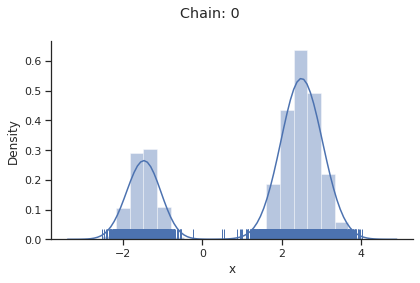

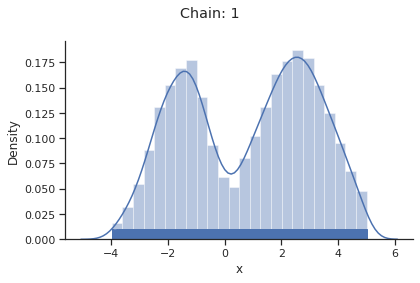

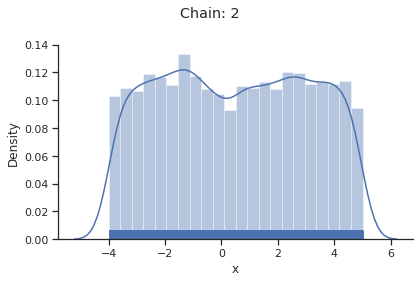

In [18]:
sample.geweke_test(result)
for i_chain in range(len(result.sample_result.betas)):
    visualize.sampling_1d_marginals(
        result, i_chain=i_chain, suptitle=f"Chain: {i_chain}")

Of interest is here finally the first chain at index `i_chain=0`, which approximates the posterior well.

### Adaptive Metropolis sampler

The problem of having to specify the proposal step variation manually can be overcome by using the `pypesto.sample.AdaptiveMetropolisSampler`, which iteratively adjusts the proposal steps to the function landscape.

In [19]:
%%time
sampler = sample.AdaptiveMetropolisSampler()
result = sample.sample(problem, 1e4, sampler, x0=np.array([0.5]))

100%|██████████| 10000/10000 [00:04<00:00, 2220.90it/s]

CPU times: user 4.63 s, sys: 171 ms, total: 4.8 s
Wall time: 4.52 s


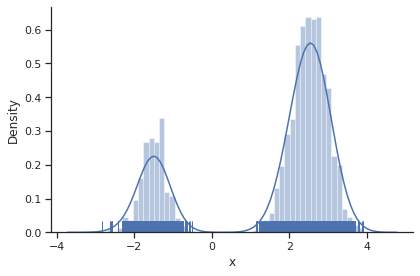

In [20]:
sample.geweke_test(result)
ax = visualize.sampling_1d_marginals(result)

### Adaptive parallel tempering sampler

The `pypesto.sample.AdaptiveParallelTemperingSampler` iteratively adjusts the temperatures to obtain good swapping rates between chains.

In [21]:
%%time
sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(), n_chains=3)
result = sample.sample(problem, 1e4, sampler, x0=np.array([0.5]))

100%|██████████| 10000/10000 [00:13<00:00, 737.08it/s]

CPU times: user 13.6 s, sys: 88.8 ms, total: 13.7 s
Wall time: 13.6 s


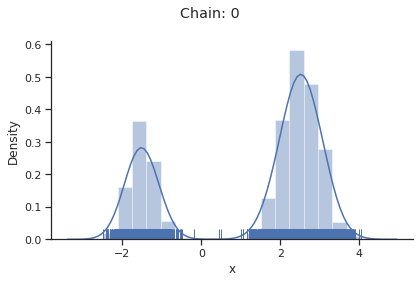

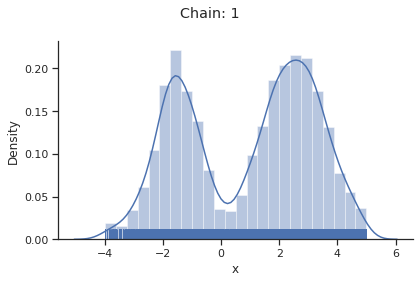

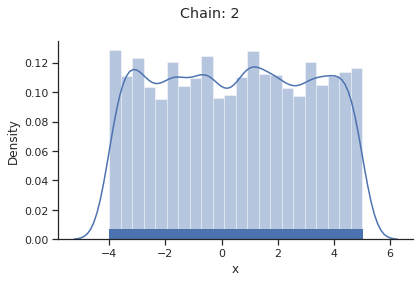

In [22]:
sample.geweke_test(result)
for i_chain in range(len(result.sample_result.betas)):
    visualize.sampling_1d_marginals(
        result, i_chain=i_chain, suptitle=f"Chain: {i_chain}")

In [23]:
result.sample_result.betas

array([1.00000000e+00, 2.27755855e-01, 2.00000000e-05])

### Pymc3 sampler

In [24]:
%%time
sampler = sample.Pymc3Sampler()
result = sample.sample(problem, 1e4, sampler, x0=np.array([0.5]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (1 chains in 1 job)
Slice: [x]
Sampling chain 0, 0 divergences: 100%|██████████| 10500/10500 [00:25<00:00, 408.54it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


CPU times: user 29 s, sys: 1.11 s, total: 30.1 s
Wall time: 30.6 s


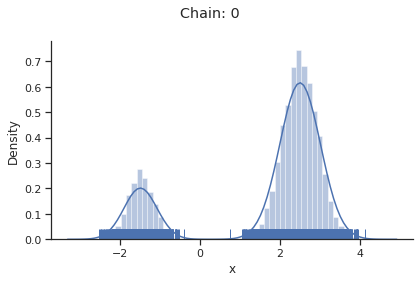

In [25]:
sample.geweke_test(result)
for i_chain in range(len(result.sample_result.betas)):
    visualize.sampling_1d_marginals(
        result, i_chain=i_chain, suptitle=f"Chain: {i_chain}")

If not specified, pymc3 chooses an adequate sampler automatically. 

## 2-dim test problem: Rosenbrock banana

The adaptive parallel tempering sampler with chains running adaptive Metropolis samplers is also able to sample from more challenging posterior distributions. To illustrates this shortly, we use the Rosenbrock function.

In [26]:
import scipy.optimize as so
import pypesto

# first type of objective
objective = pypesto.Objective(fun=so.rosen)

dim_full = 4
lb = -5 * np.ones((dim_full, 1))
ub = 5 * np.ones((dim_full, 1))

problem = pypesto.Problem(objective=objective, lb=lb, ub=ub)

In [27]:
%%time
sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(), n_chains=10)
result =sample.sample(problem, 1e4, sampler, x0=np.zeros(dim_full))

100%|██████████| 10000/10000 [00:35<00:00, 278.50it/s]


CPU times: user 35.9 s, sys: 83.6 ms, total: 36 s
Wall time: 36 s


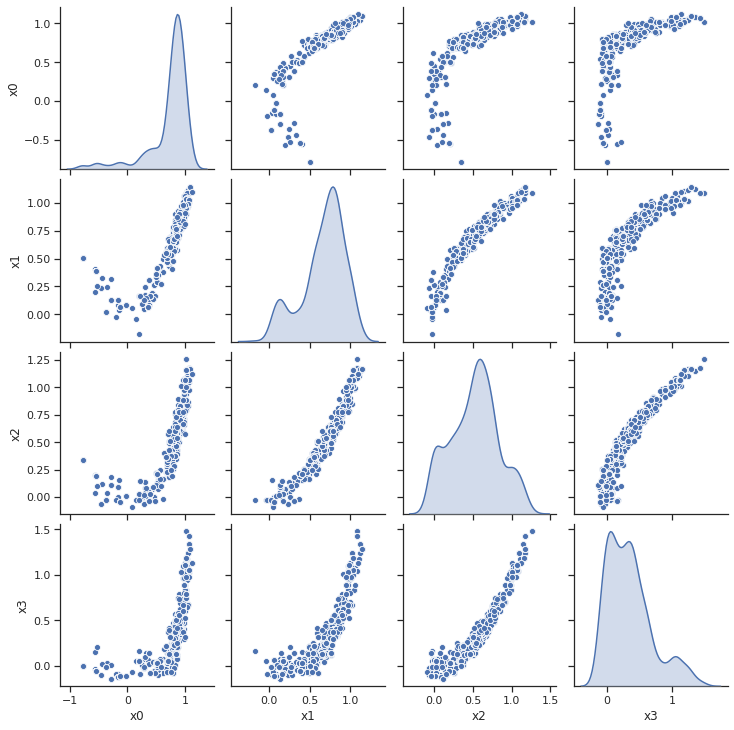

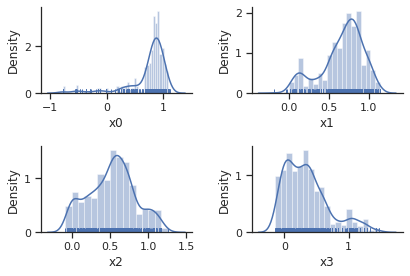

In [28]:
sample.geweke_test(result)
ax = visualize.sampling_scatter(result)
ax = visualize.sampling_1d_marginals(result)